In [210]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


In [211]:
#Load the dataset
df = pd.read_csv('OnlineRetail.csv')

In [212]:
# Display basic information about the dataset
print(df.head())
print(df.info())
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       ------------

In [213]:
# Check for missing values and drop duplicates
df.isnull().sum()
df.dropna(inplace = True)
# Clean data
df = df.dropna(subset=['CustomerID', 'Description'])
df.drop_duplicates(inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  int32  
 7   Country      401604 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 26.0+ MB


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [214]:
print(f"Number of unique products : {df['StockCode'].nunique()}")
print(f"Number of unique customers : {df['CustomerID'].nunique()}")


Number of unique products : 3684
Number of unique customers : 4372


In [215]:
#Displaying the top 10 products from the dataset
top_products = df['Description'].value_counts().head(10)
print (top_products)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
LUNCH BAG RED RETROSPOT               1345
SET OF 3 CAKE TINS PANTRY DESIGN      1224
POSTAGE                               1196
LUNCH BAG  BLACK SKULL.               1099
PACK OF 72 RETROSPOT CAKE CASES       1062
Name: count, dtype: int64


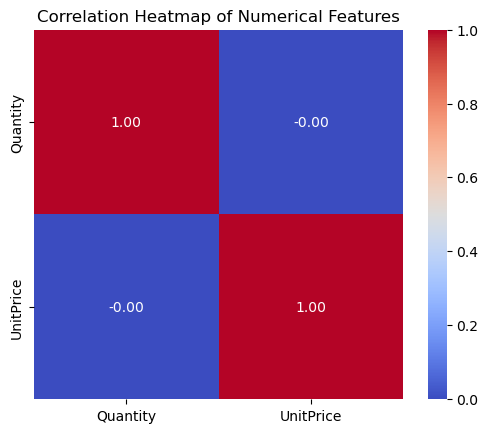

In [216]:
numeric_df = df.select_dtypes(include=['int64','float64'])

correlation_matrix = numeric_df.corr()

plt.figure() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


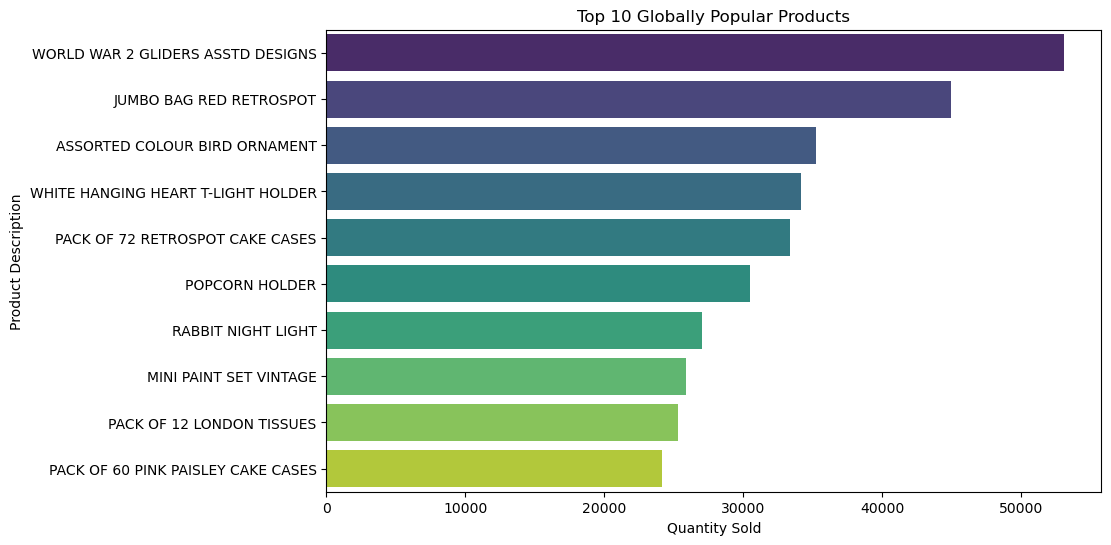

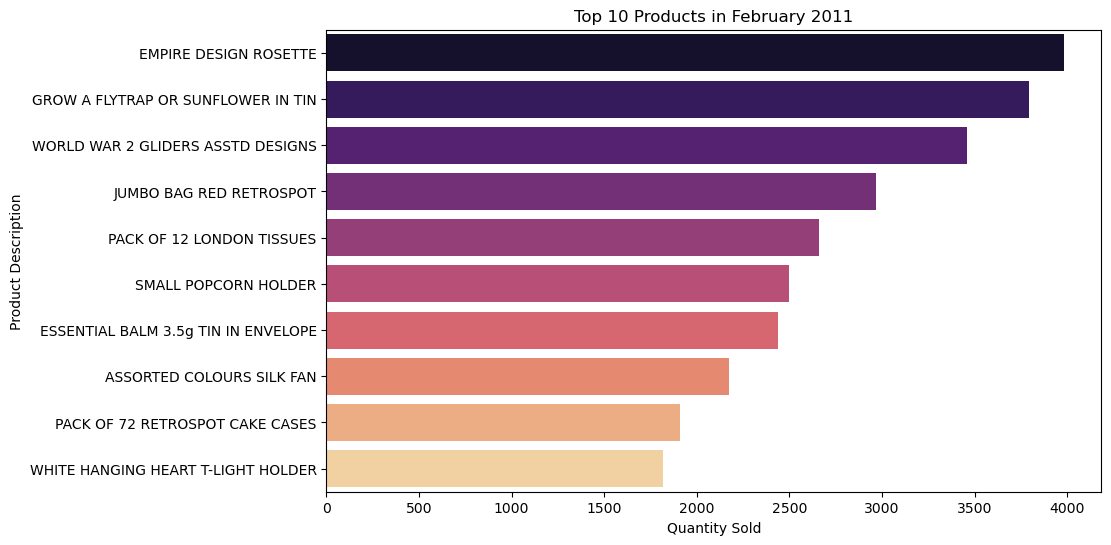

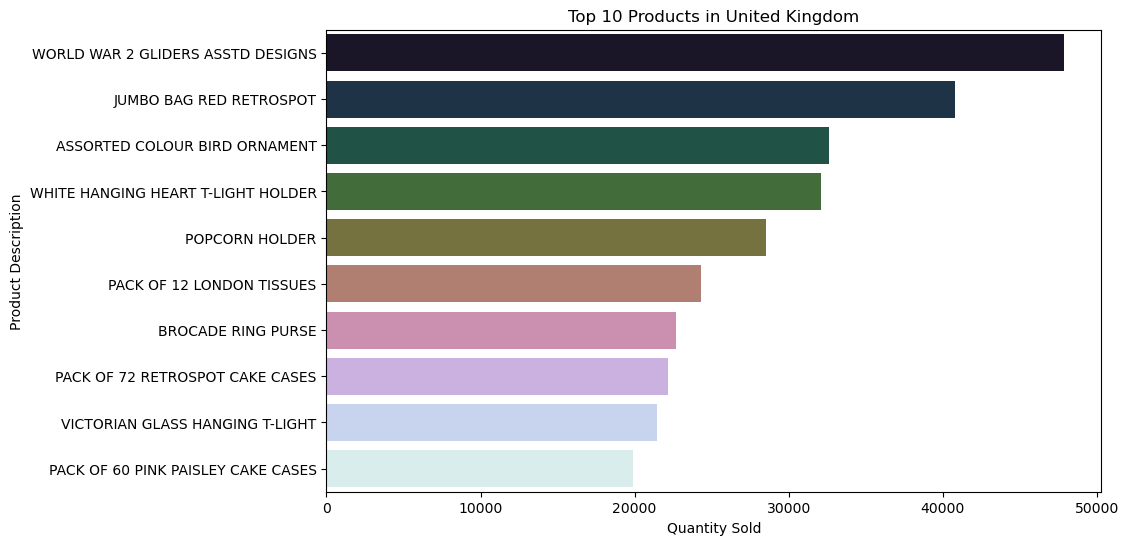

In [217]:
# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create month period & string version
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Month_str'] = df['InvoiceDate'].dt.strftime('%B %Y')  # e.g., "February 2011"

# ---------------------------
# 1. GLOBAL TOP 10 PRODUCTS
# ---------------------------
top_global = (
    df.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_global.values, y=top_global.index, palette="viridis")
plt.title('Top 10 Globally Popular Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()

# ---------------------------
# 2. MONTH-WISE TOP 10 PRODUCTS
# ---------------------------
top_month = (
    df.groupby(['Month', 'Month_str', 'Description'])['Quantity']
    .sum()
    .reset_index()
)

# Pick a month to plot
month_to_plot = "February 2011"
top_month_plot = (
    top_month[top_month['Month_str'] == month_to_plot]
    .sort_values(by='Quantity', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_month_plot['Quantity'], y=top_month_plot['Description'], palette="magma")
plt.title(f'Top 10 Products in {month_to_plot}')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()

# ---------------------------
# 3. COUNTRY-WISE TOP 10 PRODUCTS
# ---------------------------
top_country = (
    df.groupby(['Country', 'Description'])['Quantity']
    .sum()
    .reset_index()
)

# Pick a country to plot
country_to_plot = 'United Kingdom'
top_country_plot = (
    top_country[top_country['Country'] == country_to_plot]
    .sort_values(by='Quantity', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_country_plot['Quantity'], y=top_country_plot['Description'], palette="cubehelix")
plt.title(f'Top 10 Products in {country_to_plot}')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()

In [218]:

# Clean
df = df.dropna(subset=['CustomerID', 'Description'])
df['CustomerID'] = df['CustomerID'].astype(str)
df['Description'] = df['Description'].str.strip()
# CREATE USER–ITEM MATRIX

user_item_matrix = df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)


# SIMILARITY MATRICES

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_item_matrix.index,
                                  columns=user_item_matrix.index)

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)


# FUNCTIONS

def recommend_for_user(user_id, n=5):
    """User-based CF recommendations."""
    user_id = str(user_id)
    if user_id not in user_similarity_df.index:
        return None
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    similar_users_items = user_item_matrix.loc[similar_users].sum(axis=0)
    user_items = user_item_matrix.loc[user_id]
    recommendations = similar_users_items[user_items == 0].sort_values(ascending=False)
    return recommendations.head(n).index.tolist()

def recommend_items(product_name, n=5):
    """Item-based CF recommendations."""
    if product_name not in item_similarity_df.columns:
        return None
    similar_scores = item_similarity_df[product_name].sort_values(ascending=False)
    return similar_scores.iloc[1:n+1].index.tolist()

# ---------------------------
# SMART INPUT HANDLER
# ---------------------------
user_input = input("Enter Customer ID or Product Name: ").strip()

if user_input.isdigit():
    # Treat as CustomerID
    if user_input not in user_item_matrix.index:
        print(f"Customer ID {user_input} not found.")
    else:
        recs = recommend_for_user(user_input, n=10)
        print(f"\nTop recommendations for Customer {user_input}:\n")
        for r in recs:
            print(" -", r)
else:
    # Treat as Product
    if user_input not in item_similarity_df.columns:
        print(f" Product '{user_input}' not found.")
    else:
        recs = recommend_items(user_input, n=5)
        print(f"\nProducts similar to '{user_input}':\n")
        for r in recs:
            print(" -", r)


Enter Customer ID or Product Name:  17850



✅ Top recommendations for Customer 17850:

 - RED HANGING HEART T-LIGHT HOLDER
 - T-LIGHT HOLDER SWEETHEART HANGING
 - DECORATIVE WICKER HEART SMALL
 - HANGING CLEAR MINI BOTTLE
 - HOME BUILDING BLOCK WORD
 - WORLD WAR 2 GLIDERS ASSTD DESIGNS
 - LOVE BUILDING BLOCK WORD
 - CREAM SWEETHEART MINI CHEST
 - NATURAL SLATE HEART CHALKBOARD
 - CANDLEHOLDER PINK HANGING HEART


In [219]:
user_input = input("Enter Customer ID or Product Name: ").strip()

if user_input.isdigit():
    # Treat as CustomerID
    if user_input not in user_item_matrix.index:
        print(f"Customer ID {user_input} not found.")
    else:
        recs = recommend_for_user(user_input, n=10)
        print(f"\nTop recommendations for Customer {user_input}:\n")
        for r in recs:
            print(" -", r)
else:
    # Treat as Product
    if user_input not in item_similarity_df.columns:
        print(f" Product '{user_input}' not found.")
    else:
        recs = recommend_items(user_input, n=5)
        print(f"\nProducts recommended to those who bought '{user_input}':\n")
        for r in recs:
            print(" -", r)

Enter Customer ID or Product Name:  WORLD WAR 2 GLIDERS ASSTD DESIGNS



✅ Products recommended to those who bought 'WORLD WAR 2 GLIDERS ASSTD DESIGNS':

 - BALLOON WATER BOMB PACK OF 35
 - RED  HARMONICA IN BOX
 - LARGE RED RETROSPOT WINDMILL
 - TRADITIONAL WOODEN SKIPPING ROPE
 - PAPER CHAIN KIT 50'S CHRISTMAS
